# Amazon Fine Food Reviews

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from pylab import figure, axes, pie, title, show
from Word2VecUtility3 import Word2VecUtility3
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
#data = pd.read_csv('AFFReviews.csv', delimiter=",", header=0)
data = pd.read_csv('Reviews.csv', encoding='utf-8')
print(data.info())
print(data.head())
#data.to_csv('Reviews_clean.csv', index=False, encoding='utf-8')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568453 entries, 0 to 568452
Data columns (total 2 columns):
Score    568453 non-null int64
Text     568453 non-null object
dtypes: int64(1), object(1)
memory usage: 8.7+ MB
None
   Score                                               Text
0      5  I have bought several of the Vitality canned d...
1      1  Product arrived labeled as Jumbo Salted Peanut...
2      4  This is a confection that has been around a fe...
3      2  If you are looking for the secret ingredient i...
4      5  Great taffy at a great price.  There was a wid...


In [11]:
pd.__version__

'0.20.3'

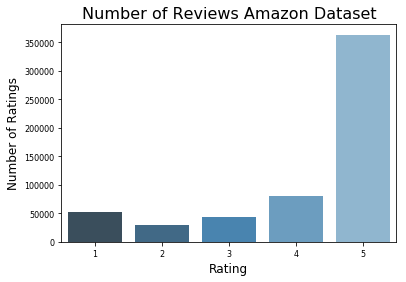

In [12]:
#Graph - Score
ax = sns.countplot(data['Score'], palette='Blues_d')
ax.set_xlabel('Rating', fontsize = 12)
ax.set_ylabel('Number of Ratings', fontsize = 12)
ax.set_title('Number of Reviews Amazon Dataset', fontsize=16)
ax.tick_params(labelsize = 8)
pylab.rcParams['figure.figsize'] = (4, 8)
plt.show()
fig = ax.get_figure()
fig.savefig("AFF.png")

In [13]:
data['Score'].value_counts()
#to sample it evenly, we'd need around 80k reviews from each

5    363121
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [14]:
#remove rows which contain ratings of 3 (Neutral and not included in our analysis.)
data = data[data.Score != 3]
print(data.head())
data['Score'].value_counts() 

   Score                                               Text
0      5  I have bought several of the Vitality canned d...
1      1  Product arrived labeled as Jumbo Salted Peanut...
2      4  This is a confection that has been around a fe...
3      2  If you are looking for the secret ingredient i...
4      5  Great taffy at a great price.  There was a wid...


5    363121
4     80655
1     52268
2     29769
Name: Score, dtype: int64

In [7]:
# #create 2 datasets and merge them. 
# negative_sample = data.loc[data.Score <=2]
# positive_sample = data.loc[data.Score >=4]

In [8]:
# print(len(negative_sample))
# print(len(positive_sample))

82037
443776


In [15]:
data.loc[data.Score <=2, 'Score'] = 0
data.loc[data.Score >=4, 'Score'] = 1

In [16]:
data['Score'].value_counts() 

1    443776
0     82037
Name: Score, dtype: int64

Create Specific Datasets

In [17]:
#Create a sample dataset so we can evenly match the amount of pos/neg examples/  
size = 164000
subdata = data.sample(n = size, random_state=520)

#subdata = subdata[pd.notnull(subdata['text'])] - to get rid of null values

print(subdata.index)
subdata.to_csv('AFF_Randomly_Distributed_164k.csv', index=False, sep=',', encoding='utf-8')

Int64Index([328304, 189166, 220149, 512982, 307255, 293924, 337360, 210412,
            469983,   2151,
            ...
            373670, 169415, 385119,  73312, 297309, 297901, 340759, 541518,
            392728, 495616],
           dtype='int64', length=164000)


In [ ]:
#Load in the sample data
pos_data = pd.read_csv('AFFpos80k.csv', index_col=False)
print(pos_data.iloc[:5])

Create Negative Examples Dataset

In [ ]:
#Create a sample dataset so we can evenly match the amount of pos/neg examples/  
size = 82000 
subdata = negative_sample.sample(n = size, random_state=520)

#subdata = subdata[pd.notnull(subdata['text'])] - to get rid of null values

print(subdata.index)
subdata.to_csv('AFFneg80k.csv', index=False, sep=',', encoding='utf-8')

In [ ]:
#Load in the sample data
neg_data = pd.read_csv('AFFneg80k.csv', index_col=False)
print(neg_data.iloc[:5])

Merge the positive and negative datasets so that we have one highly balanced dataset

In [ ]:
# stack the DataFrames on top of each other
merged = pd.concat([pos_data, neg_data], axis=0)

In [ ]:
print(merged.head())

In [ ]:
#Graph - Score
ax = sns.countplot(merged['Score'], palette='Blues_d')
ax.set_xlabel('Rating', fontsize = 12)
ax.set_ylabel('Number of Ratings', fontsize = 12)
ax.set_title('Number of Reviews Amazon', fontsize=16)
ax.tick_params(labelsize = 8)
pylab.rcParams['figure.figsize'] = (4, 8)
plt.show()
fig = ax.get_figure()
#fig.savefig("AFF.png")

In [ ]:
merged.loc[merged.Score <=2, 'Score'] = 0
merged.loc[merged.Score >=4, 'Score'] = 1
        
merged['Score'].value_counts()

In [ ]:
#Now that we have a balanced dataset, we can save it to a CSV file so that it can be used in our
#analysis

merged.to_csv('AFF_Evenly_Sampled.csv', index=False, sep=',', encoding='utf-8')

In [6]:
#Load in the new data
data = pd.read_csv('AFF_Evenly_Sampled.csv', index_col=False, encoding='utf-8')
print(data.iloc[:5])
data['Score'].value_counts()

   Score                                               Text
0      1  I like this brand. I didn't realize I was orde...
1      1  Being my wife is a licensed cosmetologist and ...
2      1  If you are looking for an upgrade from the sta...
3      1  I am so allergic to too many artificial sweete...
4      1  I have not been able to find this locally and ...


1    82000
0    82000
Name: Score, dtype: int64

In [10]:
print(data.iloc[0])

Score                                                    1
Text     I like this brand. I didn't realize I was orde...
Name: 0, dtype: object


In [ ]:
from __future__ import division
from sklearn.cross_validation import train_test_split
from Word2VecUtility import Word2VecUtility
import pickle
import pandas as pd
import numpy as np
from gensim.models import word2vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

In [ ]:
import nltk.data
#nltk.download()
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [ ]:
review_sents = []
print("Cleaning and parsing the reviews...\n")
for i in xrange( 0, len(data["Text"])):
    # sent_reviews += Word2VecUtility.review_to_sentences(data["text"][i], tokenizer)
    review_sents += Word2VecUtility3.review_to_sentences(data.iloc[i]["Text"], tokenizer)

In [ ]:
# review_sents = pickle.load(open('review_sents_1859888.pkl', 'rb'))
print(len(review_sents))
print(review_sents[:10])

In [ ]:
#count the number of words:
# review_words = []
# print("Cleaning and parsing the reviews...\n")
# for i in xrange( 0, len(data["Text"])):
#     # sent_reviews += Word2VecUtility.review_to_sentences(data["text"][i], tokenizer)
#     review_words += Word2VecUtility3.review_to_wordlist(data.iloc[i]["Text"])

In [ ]:
# # review_sents = pickle.load(open('review_sents_1859888.pkl', 'rb'))
# print(len(review_words))
# print(review_words[:5])

In [ ]:
print(data[0:10])